## Hybrid Time Steppers

### created by Yuying Liu, 05/13/2020

This script is a template mainly for benchmarking hybrid time-steppers against purely numerical time-steppers. (We also include our multiscale neural network HiTS in the comparisons.)

For numerical time-steppers, we choose to use the classic fourth-order Runge-Kutta (RK4) scheme which has a local truncation error of $O(\Delta t^5)$, which leads to a global time-stepping error of $O(\Delta t^4)$. The hybrid time-steppers are constructed from the same fourth-order Runge-Kutta (RK4) time-steppers with one large-scale neural network time-stepper at the highest level. The step size of this neural network time-stepper is set to be 0.512 for Lorenz and 10.24 for others.

Generally speaking, we find the hybrid time-steppers are more efficient than the corresponding RK45 time-steppers, at the cost of a slightly lower accuracy. The multiscale neural network HiTS cannot win over efficieny although they were shown to be efficient when compared to single time-scale neural network time-steppers.

This script can be used to reproduce:
- Figure 6B
- Figure 9
- Table 9

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# define functions
def hyperbolic_rhs(x):
    return torch.stack([(-0.05)*x[:, 0], (-1.0)*(x[:, 1]-x[:, 0]**2)], dim=1)

def cubic_rhs(x):
    return torch.stack([-0.1*x[:, 0]**3+2*x[:, 1]**3, 
                        -2*x[:, 0]**3-0.1*x[:, 1]**3], dim=1)

def van_der_pol_rhs(x):
    return torch.stack([x[:, 1], (2.0)*(1-x[:, 0]**2)*x[:, 1]-x[:, 0]], dim=1)


def hopf_rhs(x):
    return torch.stack([torch.zeros(x[:, 0].shape), 
                        x[:, 0]*x[:, 1]+x[:, 2]-x[:, 1]*(x[:, 1]**2+x[:, 2]**2), 
                        -x[:, 1]+x[:, 0]*x[:, 2]-x[:, 2]*(x[:, 1]**2+x[:, 2]**2)], dim=1)

def lorenz_rhs(x):
    return torch.stack([10*(x[:, 1]-x[:, 0]), x[:, 0]*(28-x[:, 2])-x[:, 1], 
                        x[:, 0]*x[:, 1]-(8/3)*x[:, 2]], dim=1)

# runge-kutta time stepper (uniform step size)
def runge_kutta_stepper(fun, y0, h, k_steps):
    """
    :param fun: callable, right-hand side of the system
    :param y0: torch array, the initial conditions
    :param h: float, time step size
    :param k_steps: int, number of steps forward
    :return: computed solution
    """
    # explicit runge-kutta for autonomous system
    batch_size, n_dim = y0.shape
    sol = torch.zeros(batch_size, k_steps+1, n_dim).float()
    sol[:, 0, :] = torch.tensor(y0).float()
    
    m = 4
    b = [1 / 6, 1 / 3, 1 / 3, 1 / 6]
    A = [[], [1 / 2], [0, 1 / 2], [0, 0, 1]]
    
    y_prev = y0
    for t in range(k_steps):
        ks = [fun(y_prev)]
        for i in range(1, m):
            y = y_prev
            for j in range(i):
                y = y + A[i][j]*ks[j]*h
            ks.append(fun(y))

        y_next = y_prev
        for i in range(m):
            y_next = y_next + h*b[i]*ks[i]
            
        # update
        sol[:, t+1, :] = y_next
        y_prev = y_next
        
    return sol

In [3]:
# adjustables
n = 2                         # n = 3 for Hopf and lorenz, and n = 2 for others
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'            

In [4]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
ks = list(range(11))
step_sizes = [2**k for k in ks]

# rhs for simulation
if system is 'Hyperbolic':
    sys_rhs = hyperbolic_rhs
elif system is 'Cubic':
    sys_rhs = cubic_rhs
elif system is 'VanDerPol':
    sys_rhs = van_der_pol_rhs
elif system is 'Hopf':
    sys_rhs = hopf_rhs
elif system is 'Lorenz':
    sys_rhs = lorenz_rhs
else:
    raise ValueError('system does not exist!')

### load data & models

In [5]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [6]:
# load models
models = list()
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D64.pt
load model_D128.pt
load model_D256.pt
load model_D512.pt
load model_D1024.pt


/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'ResNet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the ori

### Part I: benchmarks

In [7]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [8]:
# rk45
hs = list()
rk45_mse = list()
rk45_times = list()
for k in range(0, 5):
    h = dt*2**k
    k_steps = int(n_steps//(2**k)+1)
    print('simulate {} steps forward with step size: {}'.format(k_steps, h))
    start = time.time()
    y_preds = runge_kutta_stepper(fun=sys_rhs, y0=torch.tensor(test_data[:, 0, :]).float(), h=h, k_steps=k_steps)
    if k < 0:
        # sub-sampling
        y_preds = y_preds[:, 1:int(n_steps//(2**k)):(2**(-k)), :]
    else:
        # interpolating
        t_eval = [i*h for i in range(k_steps+1)]
        cs = scipy.interpolate.interp1d(t_eval, y_preds.detach().numpy(), kind='linear', axis=1)
        y_preds = torch.tensor(cs(t)).float()
    end = time.time()
    hs.append(h)
    rk45_times.append(end - start)
    rk45_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

simulate 5121 steps forward with step size: 0.01


/Users/liuyuyingufo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


simulate 2561 steps forward with step size: 0.02
simulate 1281 steps forward with step size: 0.04
simulate 641 steps forward with step size: 0.08
simulate 321 steps forward with step size: 0.16


In [9]:
# hybrid model

hybrid_mse = list()
hybrid_times = list()
for h in hs:
    start = time.time()
    ### 1. use nn model
    model = models[10]
    x_init = torch.tensor(test_data[:, 0, :]).float()
    n_test, n_dim = x_init.shape
    extended_n_steps = n_steps + model.step_size
    n_forward = int(np.ceil((n_steps + 1)/model.step_size)) - 1
    y_preds = torch.zeros(n_test, n_forward + 1, n_dim).float()
    y_preds[:, 0, :] = x_init
    y_prev = x_init
    for i in range(n_forward):
        y_next = model(y_prev)
        y_preds[:, i+1, :] = y_next
        y_prev = y_next

    ### 2. use rk45
    k_steps = int(model.step_size/(h/dt)) - 1
    y_preds = y_preds.reshape(-1, n_dim)
    y_preds = runge_kutta_stepper(fun=sys_rhs, y0=y_preds, h=h, k_steps=k_steps)
    y_preds = y_preds.reshape(n_test, -1, n_dim)[:, :int(n_steps//(h/dt))+1, :]

    ### 3. interpolation
    if h/dt < 1:
        # sub-sampling
        y_preds = y_preds[:, 1::int(dt/h), :]
    else:
        # interpolating
        t_eval = [i*h for i in range(int(n_steps//(h/dt))+1)]
        cs = scipy.interpolate.interp1d(t_eval, y_preds.detach().numpy(), kind='linear', axis=1)
        y_preds = torch.tensor(cs(t)).float()

    end = time.time()
    hybrid_times.append(end - start)    
    hybrid_mse.append(criterion(y_preds, torch.tensor(test_data[:, 1:, :]).float()).mean(-1))

/Users/liuyuyingufo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

# multiscale NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_mse = criterion(y_preds, torch.tensor(test_data[:, 1:, :]).float()).mean(0).mean(-1).detach().numpy()


use models 3 - 10.


(array([-16., -14., -12., -10.,  -8.,  -6.,  -4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

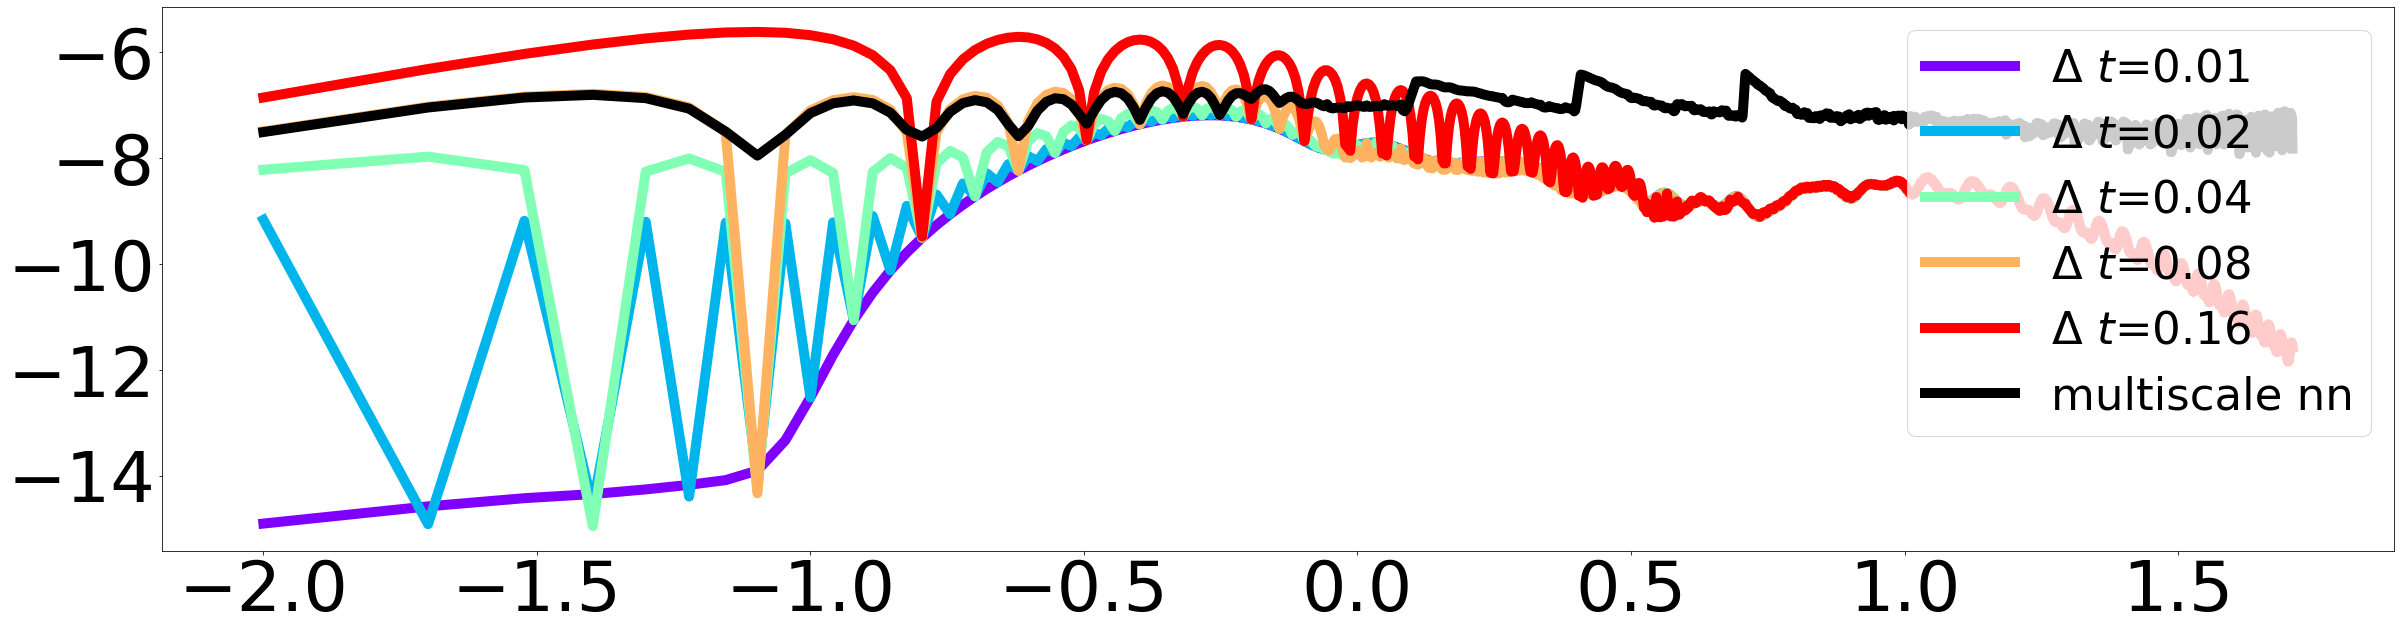

In [11]:
# accuracy: multiscale vs rk45
fig = plt.figure(figsize=(40, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(rk45_mse))))
for k in range(len(rk45_mse)):
    err = rk45_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(np.log10(t), np.log10(mean), linestyle='-', color=rgb, linewidth=10, label='$\Delta\ t$={}'.format(hs[k]))
plt.plot(np.log10(t), np.log10(multiscale_mse), linestyle='-', color='k', linewidth=10, label='multiscale nn')
plt.legend(fontsize=45, loc='upper right')
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

(array([-16., -14., -12., -10.,  -8.,  -6.,  -4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

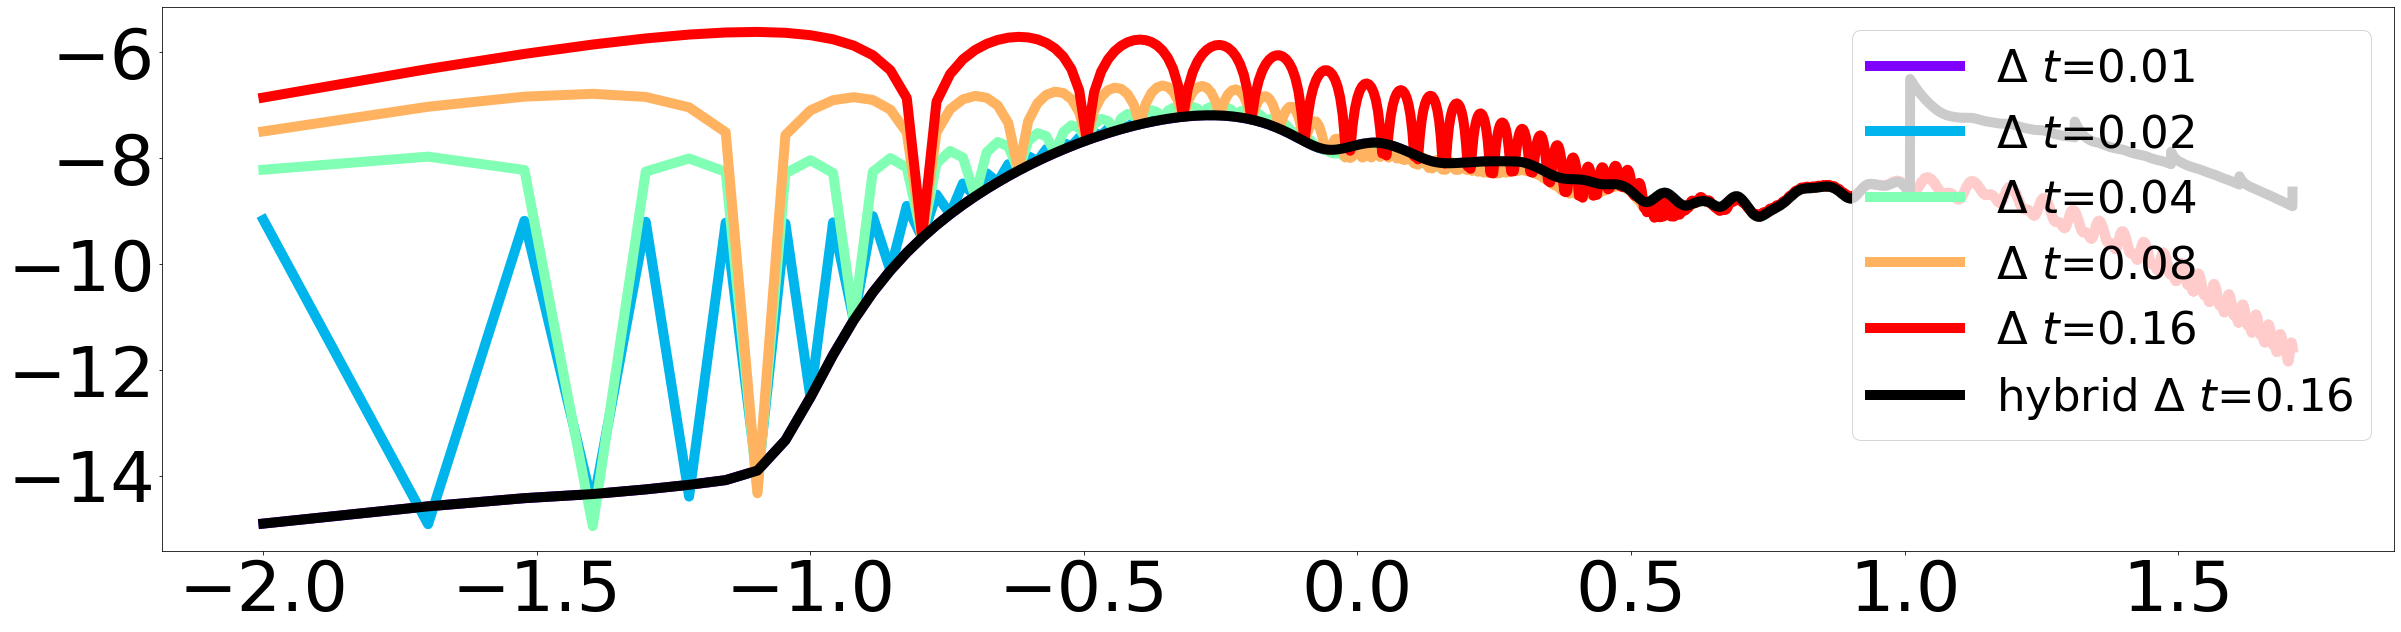

In [12]:
# accuracy: hybrid vs rk45
fig = plt.figure(figsize=(40, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(rk45_mse))))
for k in range(len(rk45_mse)):
    rgb = next(colors)
    plt.plot(np.log10(t), np.log10(rk45_mse[k].mean(0).detach().numpy()), linestyle='-', color=rgb, linewidth=10, label='$\Delta\ t$={}'.format(hs[k]))
plt.plot(np.log10(t), np.log10(hybrid_mse[0].mean(0).detach().numpy()), linestyle='-', color='k', linewidth=10, label='hybrid $\Delta\ t$={}'.format(hs[k]))
plt.legend(fontsize=45, loc='upper right')
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

In [13]:
# computation time
for i in range(len(rk45_times)):
    print('RK45 (Dt={}): computing time {}s, mse {}'.format(hs[i], rk45_times[i], rk45_mse[i].mean()))
for i in range(len(hybrid_times)):
    print('Hybrid (RK45 dt={}): computing time {}s, mse {}'.format(hs[i], hybrid_times[i], hybrid_mse[i].mean()))
print('ensembled multiscale nn: computing time {}s'.format(multiscale_time))

RK45 (Dt=0.01): computing time 2.5805282592773438s, mse 1.5892825944163746e-09
RK45 (Dt=0.02): computing time 1.2266428470611572s, mse 1.6090807575253052e-09
RK45 (Dt=0.04): computing time 0.6361291408538818s, mse 1.7303253274647545e-09
RK45 (Dt=0.08): computing time 0.3373110294342041s, mse 2.8660469553187795e-09
RK45 (Dt=0.16): computing time 0.18375182151794434s, mse 1.781375935649976e-08
Hybrid (RK45 dt=0.01): computing time 1.0780742168426514s, mse 1.720337827748608e-08
Hybrid (RK45 dt=0.02): computing time 0.5377109050750732s, mse 1.72422964794805e-08
Hybrid (RK45 dt=0.04): computing time 0.3055458068847656s, mse 1.7403918306513333e-08
Hybrid (RK45 dt=0.08): computing time 0.19039607048034668s, mse 1.8629487286148105e-08
Hybrid (RK45 dt=0.16): computing time 0.16396188735961914s, mse 3.376121071596572e-08
ensembled multiscale nn: computing time 0.7065389156341553s


### Part II: collect data and plot

In [17]:
# each time we run Part I, we print, collect and copy-paste the data below to make the plot

print(rk45_times)
print(hybrid_times)
print([i.mean().item() for i in rk45_mse])
print([i.mean().item() for i in hybrid_mse])

[2.5805282592773438, 1.2266428470611572, 0.6361291408538818, 0.3373110294342041, 0.18375182151794434]
[1.0780742168426514, 0.5377109050750732, 0.3055458068847656, 0.19039607048034668, 0.16396188735961914]
[1.5892825944163746e-09, 1.6090807575253052e-09, 1.7303253274647545e-09, 2.8660469553187795e-09, 1.781375935649976e-08]
[1.720337827748608e-08, 1.72422964794805e-08, 1.7403918306513333e-08, 1.8629487286148105e-08, 3.376121071596572e-08]


In [15]:
to_plot = dict()

# different systems
to_plot['hyperbolic'] = dict()
to_plot['cubic'] = dict()
to_plot['vanderpol'] = dict()
to_plot['hopf'] = dict()
to_plot['lorenz'] = dict()

# for each system, we record rk45_times, hybrid times, rk45 mse, hybrid mse
to_plot['hyperbolic']['rk45_times'] = [2.5515570640563965, 
                                       1.282386064529419, 
                                       0.7468647956848145, 
                                       0.46175122261047363, 
                                       0.3016989231109619]
to_plot['hyperbolic']['hybrid_times'] = [1.359079360961914,
                                         0.7239298820495605,
                                         0.378309965133667,
                                         0.2414379119873047,
                                         0.1881718635559082]
to_plot['hyperbolic']['rk45_mse'] = [1.8875652152416933e-09,
                                     1.907878743878655e-09,
                                     2.031321555406862e-09,
                                     3.1758597973663427e-09,
                                     1.815884331790585e-08]
to_plot['hyperbolic']['hybrid_mse'] = [1.749159395103561e-08,
                                       1.753051925845739e-08,
                                       1.769388724426335e-08,
                                       1.892728995755988e-08,
                                       3.409214954785966e-08]

to_plot['cubic']['rk45_times'] = [3.1800057888031006, 
                                  1.600844144821167, 
                                  1.0148987770080566, 
                                  0.6374878883361816, 
                                  0.4306020736694336]
to_plot['cubic']['hybrid_times'] = [2.252937078475952, 
                                    0.9558579921722412, 
                                    0.5451419353485107, 
                                    0.30314207077026367, 
                                    0.2309281826019287]
to_plot['cubic']['rk45_mse'] = [4.7856272431090474e-05, 
                                4.786450881510973e-05, 
                                4.785501369042322e-05, 
                                4.7661094868090004e-05, 
                                4.577979780151509e-05]
to_plot['cubic']['hybrid_mse'] = [0.00028481491608545184, 
                                  0.0002847960276994854, 
                                  0.00028476546867750585, 
                                  0.0002846904390025884, 
                                  0.0002845262351911515]

to_plot['vanderpol']['rk45_times'] = [2.8181591033935547, 
                                      1.2971210479736328, 
                                      0.7823240756988525, 
                                      0.4154036045074463, 
                                      0.30220603942871094]
to_plot['vanderpol']['hybrid_times'] = [1.373539924621582, 
                                        0.6981229782104492, 
                                        0.4207491874694824, 
                                        0.290363073348999, 
                                        0.22491788864135742]
to_plot['vanderpol']['rk45_mse'] = [0.002034061821177602, 
                                    0.0020334713626652956, 
                                    0.0020344422664493322, 
                                    0.002096602227538824, 
                                    0.004136851988732815]
to_plot['vanderpol']['hybrid_mse'] = [0.0202387236058712, 
                                      0.020216524600982666, 
                                      0.020159779116511345, 
                                      0.020013365894556046, 
                                      0.020044643431901932]

to_plot['hopf']['rk45_times'] = [3.931025981903076, 
                                 2.2118117809295654, 
                                 1.0702033042907715, 
                                 0.6028957366943359, 
                                 0.3531649112701416]
to_plot['hopf']['hybrid_times'] = [1.8880231380462646, 
                                   1.0132718086242676, 
                                   0.5919177532196045, 
                                   0.3700079917907715, 
                                   0.26758813858032227]
to_plot['hopf']['rk45_mse'] = [0.000978639698587358, 
                               0.0009786543669179082, 
                               0.0009787158342078328, 
                               0.0009790553012862802, 
                               0.000980524579063058]
to_plot['hopf']['hybrid_mse'] = [8.540391718270257e-05, 
                                 8.53160599945113e-05, 
                                 8.522450661985204e-05, 
                                 8.535884990124032e-05, 
                                 8.744753722567111e-05]

to_plot['lorenz']['rk45_times'] = [3.870251178741455, 
                                   1.9730830192565918, 
                                   1.1743509769439697, 
                                   0.9866311550140381, 
                                   0.603358268737793]
to_plot['lorenz']['hybrid_times'] = [3.172991991043091, 
                                     1.784787893295288, 
                                     0.9856622219085693, 
                                     0.7384567260742188, 
                                     0.6247439384460449]
to_plot['lorenz']['rk45_mse'] = [2.5492217540740967, 
                                 2.5497217178344727, 
                                 2.549838066101074, 
                                 2.549532890319824, 
                                 2.54951548576355]
to_plot['lorenz']['hybrid_mse'] = [24.452871322631836, 
                                   24.440109252929688, 
                                   24.417211532592773, 
                                   24.37224769592285, 
                                   24.280942916870117]

(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

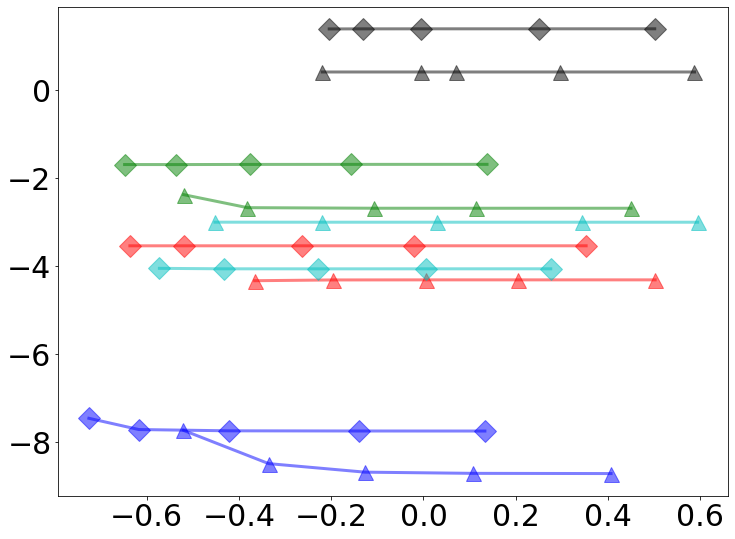

In [16]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.log10(to_plot['hyperbolic']['rk45_times']), np.log10(to_plot['hyperbolic']['rk45_mse']), 'b-^', 
         np.log10(to_plot['hyperbolic']['hybrid_times']), np.log10(to_plot['hyperbolic']['hybrid_mse']), 'b-D', 
         markersize=15, linewidth=3.0, alpha=0.5, label='Hyperbolic')
plt.plot(np.log10(to_plot['cubic']['rk45_times']), np.log10(to_plot['cubic']['rk45_mse']), 'r-^', 
         np.log10(to_plot['cubic']['hybrid_times']), np.log10(to_plot['cubic']['hybrid_mse']), 'r-D', 
         markersize=15, linewidth=3.0, alpha=0.5, label='Cubic')
plt.plot(np.log10(to_plot['vanderpol']['rk45_times']), np.log10(to_plot['vanderpol']['rk45_mse']), 'g-^', 
         np.log10(to_plot['vanderpol']['hybrid_times']), np.log10(to_plot['vanderpol']['hybrid_mse']), 'g-D', 
         markersize=15, linewidth=3.0, alpha=0.5, label='Van der Pol')
plt.plot(np.log10(to_plot['hopf']['rk45_times']), np.log10(to_plot['hopf']['rk45_mse']), 'c-^', 
         np.log10(to_plot['hopf']['hybrid_times']), np.log10(to_plot['hopf']['hybrid_mse']), 'c-D', 
         markersize=15, linewidth=3.0, alpha=0.5, label='Hopf')
plt.plot(np.log10(to_plot['lorenz']['rk45_times']), np.log10(to_plot['lorenz']['rk45_mse']), 'k-^', 
         np.log10(to_plot['lorenz']['hybrid_times']), np.log10(to_plot['lorenz']['hybrid_mse']), 'k-D', 
         markersize=15, linewidth=3.0, alpha=0.5, label='Lorenz')

# plt.legend(bbox_to_anchor=(1, 1), fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)